In [7]:
%pylab inline

import os.path as op
import sys
import matplotlib.pyplot as plt
import glob

import io3d
import sed3

sys.path.append(op.expanduser("~/projects/bodynavigation"))
sys.path.append(op.abspath("../"))

import bodynavigation
pt = op.expanduser("~/projects/imtools")
sys.path.append(pt)
import imtools
# reload(imtools)

Populating the interactive namespace from numpy and matplotlib


C:\Miniconda2\envs\lisa\lib\site-packages\IPython\core\magics\pylab.py:161: UserWarning: pylab import has clobbered these variables: ['copy']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [17]:
sliver_reference_dir = op.expanduser("~/data/medical/orig/sliver07/training/")

## Train

Prepare function to calculate feature vector from 3D to [1D x number_of_features]

In [18]:
def localization_fv(data3d, voxelsize_mm):        # scale
        fv = []
        # f0 = scipy.ndimage.filters.gaussian_filter(data3d, sigma=3).reshape(-1, 1)
        #f1 = scipy.ndimage.filters.gaussian_filter(data3dr, sigma=1).reshape(-1, 1) - f0
        #f2 = scipy.ndimage.filters.gaussian_filter(data3dr, sigma=5).reshape(-1, 1) - f0
        #f3 = scipy.ndimage.filters.gaussian_filter(data3dr, sigma=10).reshape(-1, 1) - f0
        #f4 = scipy.ndimage.filters.gaussian_filter(data3dr, sigma=20).reshape(-1, 1) - f0
        # position asdfas
        import bodynavigation as bn
        ss = bn.BodyNavigation(data3d, voxelsize_mm)
        fd1 = ss.dist_to_lungs().reshape(-1, 1)
        fd2 = ss.dist_to_spine().reshape(-1, 1)
        fd3 = ss.dist_sagittal().reshape(-1, 1)
        fd4 = ss.dist_coronal().reshape(-1, 1)
        fd5 = ss.dist_axial().reshape(-1, 1)
        fd6 = ss.dist_to_surface().reshape(-1, 1)
        fd7 = ss.dist_diaphragm().reshape(-1, 1)
        fd8 = ss.dist_to_chest().reshape(-1, 1)   # nove
        fd9 = ss.dist_to_ribs().reshape(-1, 1)    # nove
        

        # f6 = scipy.ndimage.filters.gaussian_filter(data3d, sigma=[20, 1, 1]).reshape(-1, 1) - f0
        # f7 = scipy.ndimage.filters.gaussian_filter(data3d, sigma=[1, 20, 1]).reshape(-1, 1) - f0
        # f8 = scipy.ndimage.filters.gaussian_filter(data3d, sigma=[1, 1, 20]).reshape(-1, 1) - f0

        # print "fv shapes ", f0.shape, fd2.shape, fd3.shape
        fv = np.concatenate([
                # f0,
#                 f1, f2, f3, f4,
                fd1, fd2, fd3, fd4, fd5, fd6, fd7, fd8, fd9
                #f6, f7, f8
            ], 1)


        return fv

In [19]:
import imtools.trainer3d
import imtools.datasets
ol = imtools.trainer3d.Trainer3D()
ol.feature_function = localization_fv

for one in imtools.datasets.sliver_reader(
    "*[0-7].mhd", read_seg=True,
    sliver_reference_dir=sliver_reference_dir):
    
    numeric_label, vs_mm, oname, orig_data, rname, ref_data = one
    ol.add_train_data(orig_data, ref_data, voxelsize_mm=vs_mm)
    
ol.fit()

TypeError: long() argument must be a string or a number, not 'NoneType'

## Testing

In [5]:
one = list(imtools.datasets.sliver_reader("*018.mhd", read_seg=True))[0]
numeric_label, vs_mm, oname, orig_data, rname, ref_data = one
fit = ol.predict(orig_data, voxelsize_mm=vs_mm)

(163, 253, 253)
(10433467,)


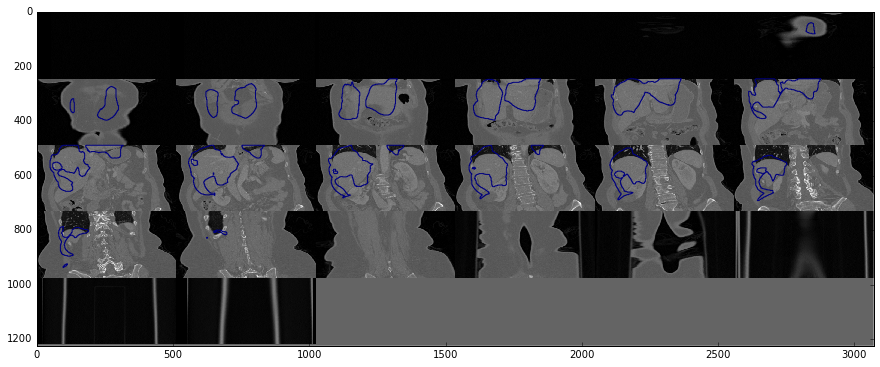

In [6]:
plt.figure(figsize=(15,10))
sed3.show_slices(orig_data, fit, slice_step=20, axis=1, flipV=True)

### Evaluation

In [9]:
import lisa.volumetry_evaluation
results = lisa.volumetry_evaluation.compare_volumes_sliver(ref_data, fit, vs_mm)

{'avgd': 12.031323575619316,
 'err1_mm3': 651297.31080045528,
 'err1_percent': 33.201476030839608,
 'err2_mm3': 976534.7324271265,
 'err2_percent': 49.781250397171064,
 'maxd': 81.199392314138294,
 'rmsd': 249.99430098132265,
 'sliver_avgd_pts': 0,
 'sliver_maxd_pts': 0,
 'sliver_overall_pts': 5.8762045691008975,
 'sliver_rmsd_pts': 0,
 'sliver_vd_pts': 29.381022845504489,
 'sliver_voe_pts': 0,
 'vd': 18.078458151550851,
 'voe': 41.491363214005339,
 'volume1_mm3': 1799032.9645383554,
 'volume2_mm3': 2124270.3861650266}

### Saving results

In [3]:
import json
import pandas as pd

import matplotlib
import numpy as np
import copy

#matplotlib.style.use('ggplot')

In [1]:
def load_json(name):
    """ Nacte .json soubor a vrati slovnik """
    mydata = {}
    with open(name) as d:
        mydata = json.load(d)
        d.close()
    return mydata


def save_json(jsondata, name):
    """ Ulozi slovnik do .json souboru """
    filepath = os.path.dirname(os.path.abspath(__file__))+"/"+str(name)
    with open(filepath, 'w') as f:
        json.dump(jsondata, f)

In [17]:
results_reference_dir = (op.abspath("../doc/organ_training_results/"))+"/"
results_filename = "results.json"
         
save_json(results, results_reference_dir+results_filename)

### Visualization

In [30]:
def sort_values(values):
    """ Seradi atributy jak chceme """
    
    new = list()
    keys = ["volume", "err1_mm3", "err2_mm3", "percent",
            "voe", "vd", "maxd", "avgd", "rmsd", "overall"]
    for key in keys:
        new.extend([value for value in values if key in value])
    return new


def compare_results(results):
    """ Porovna vysledky jednotlivych variant """
    
    columns = results.keys()
    values = results.values()[0].keys()
    values = sort_values(values)
    data = np.zeros((len(values), len(columns)))
    
    for c, column in enumerate(columns):
        for v, value in enumerate(values):
            data[v, c] = results[column][value]
    
    # normalizace dat
    data = data * (1 / np.array([np.sum(data, axis=1)]).T)
    
    # vykresleni dat
    step = 6 #len(data) # po castech je vhodne step = 6
    for i in np.arange(0, len(data), step):
        
        df2 = pd.DataFrame(data[i: min(len(data), i+step)], 
                           index=values[i: min(len(data), i+step)],
                           columns=columns)
        df2.plot.barh(fontsize=14, sort_columns=True, figsize=(15, 8), grid=True, title="Testing results comparison")
        plt.savefig(results_reference_dir+str(i)+"-"+str(i+step)+"_feature.png")
        plt.show()

C:\Miniconda2\envs\lisa\lib\site-packages\ipykernel\__main__.py:25: RuntimeWarning: divide by zero encountered in divide
C:\Miniconda2\envs\lisa\lib\site-packages\ipykernel\__main__.py:25: RuntimeWarning: invalid value encountered in multiply


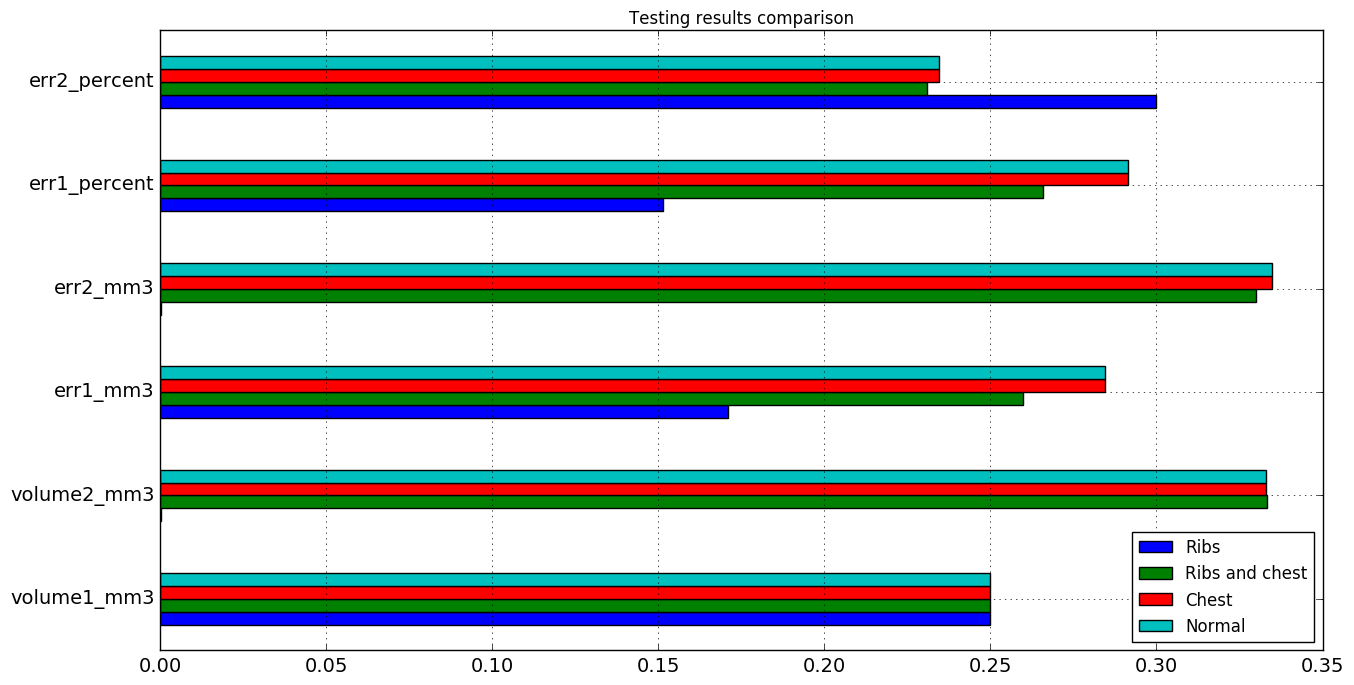

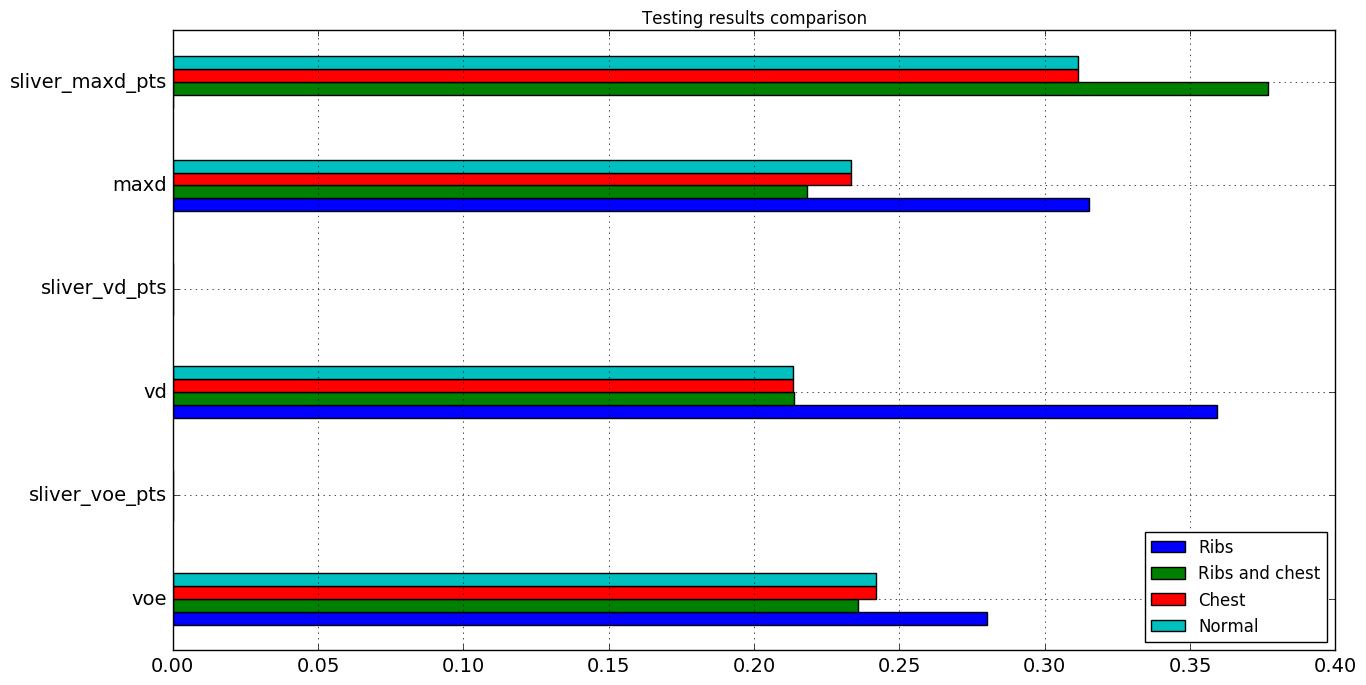

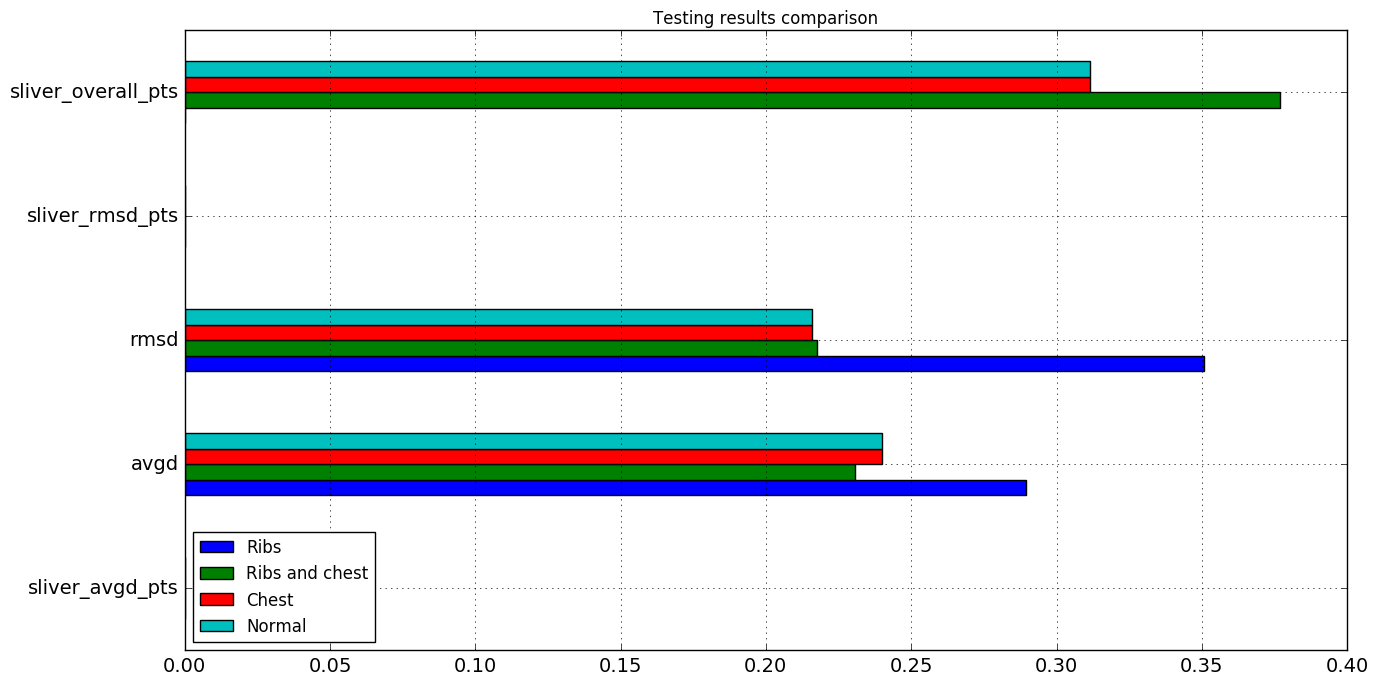

In [31]:
# nacteni vysledku
normal = load_json(results_reference_dir+"results_normal.json")
ribs = load_json(results_reference_dir+"results_ribs.json")
chest = load_json(results_reference_dir+"results_chest.json")
ribs_chest = load_json(results_reference_dir+"results_chest_ribs.json")

results = {"Normal": normal,
           "Ribs": ribs,
           "Chest": chest,
           "Ribs and chest": ribs_chest}

# vizualizace
compare_results(results)

#### Notes
**Nove:** 
    - matplotlib
    - imtools